<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_05_02_survival_analysis_subdistribution_hazard_regression_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 5.2 Subdistribution Hazard Regression


**Subdistribution Hazard Regression** (also known as the **Fine–Gray model**) is a statistical method for analyzing **competing risks data**—situations where an individual is at risk of experiencing **more than one type of event**, and the occurrence of one event **precludes** the others.

It was introduced by **Fine and Gray (1999)** to directly model the effect of covariates on the **cumulative incidence function (CIF)**, which represents the **absolute risk** (or probability) of experiencing a specific event by time *t*, in the presence of competing events.


In competing risks:

- **Cause-specific hazard (CSH) models** model the instantaneous rate of an event **assuming competing events are censored**.
  - Answers: *"What factors influence the biological mechanism or etiology of this event?"*
  
- However, CSH **does not directly translate** to the **absolute risk** (CIF), because a covariate may increase the hazard of the event of interest but *decrease* its cumulative incidence if it strongly increases the risk of a competing event.

The **Fine–Gray model** addresses this by modeling the **subdistribution hazard**, which is constructed so that **proportional hazards on this scale implies proportional CIFs**.



##  Overview


For an event of interest (e.g., cause 1), the **subdistribution hazard** is defined as:

$$
\lambda_1^{SD}(t \mid \mathbf{x}) = \lim_{\Delta t \to 0} \frac{\mathbb{P}(t \leq T \leq t + \Delta t, \text{cause} = 1 \mid T > t \text{ or } (T \leq t \text{ and cause} \neq 1), \mathbf{x})}{\Delta t}
$$

In words:  

> It’s the instantaneous rate of failing from cause 1 at time *t*, **among those who have not yet experienced cause 1**—**including individuals who already failed from a competing cause**.

This is **not a true hazard** (since the risk set includes people who are no longer at risk), but a **"pseudo-hazard"** designed to link directly to the CIF.


Under the **Fine–Gray proportional subdistribution hazards model**:

$$
\lambda_1^{SD}(t \mid \mathbf{x}) = \lambda_{10}^{SD}(t) \exp(\boldsymbol{\beta}^\top \mathbf{x})
$$

Then the **cumulative incidence function** is:

$$
F_1(t \mid \mathbf{x}) = 1 - \left[1 - F_1(t \mid \mathbf{x} = \mathbf{0})\right]^{\exp(\boldsymbol{\beta}^\top \mathbf{x})}
$$

Thus, **covariate effects directly scale the baseline CIF**, making interpretation in terms of **absolute risk differences** more intuitive.




### When to Use Subdistribution Hazard Regression?


Use the **Fine–Gray model** when your goal is:

- **Risk prediction**: estimating *absolute risk* of an event in the presence of competing risks.
- **Clinical decision-making**: e.g., “What is the 5-year risk of cancer recurrence, given that death from other causes is possible?”
- **Public health planning**: understanding population-level burden of specific outcomes.

> Note:  **Do NOT use Fine–Gray for etiologic inference** (e.g., “Does this gene cause the disease?”). For that, use **cause-specific hazards**.



### CSH vs. Fine–Gray


| Feature | Cause-Specific Hazard (CSH) | Subdistribution Hazard (Fine–Gray) |
|--------|----------------------------|-----------------------------------|
| **Risk set** | Only those still event-free | Those not yet failed from **this cause** (includes competing failures) |
| **Models** | Instantaneous event rate | Cumulative incidence (absolute risk) |
| **Use for** | Etiology, biological mechanisms | Risk prediction, clinical prognosis |
| **Interpretation** | “Effect on rate of event” | “Effect on absolute risk of event” |
| **Censoring competing events?** | Yes | No (they remain in risk set) |



## Cheeck and Load Required Packages

In [1]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'scikit-survival', 'lifelines', 'statsmodels']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
Installing scikit-learn...
Failed to install scikit-learn: No module named 'scikit-learn'
Error with package scikit-learn: No module named 'scikit-learn'
Installing scikit-survival...
Failed to install scikit-survival: No module named 'scikit-survival'
Error with package scikit-survival: No module named 'scikit-survival'
Installing lifelines...
lifelines installed successfully
statsmodels is already installed
Installed packages:
✓ pandas
✓ numpy
✓ matplotlib
✓ seaborn
✗ scikit-learn
✗ scikit-survival
✓ lifelines
✓ statsmodels


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, brier_score_loss
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Subdistribution Hazard Regression in Python

### Load and Explore Data


n the period 1962-77, 205 patients with malignant melanoma (cancer of the skin) had a radical operation performed at Odense University Hospital, Denmark. All patients were followed until the end of 1977 by which time 134 were still alive while 71 had died (of out whom 57 had died from cancer and 14 from other causes).

`time`: time in days from operation

`status`: a numeric with values 0=censored 1=death.malignant.melanoma 2=death.other.causes

`event`: a factor with levels censored death.malignant.melanoma death.other.causes

`invasion`: a factor with levels level.0, level.1, level.2

`ici`: inflammatory cell infiltration (IFI): 0, 1, 2 or 3

`epicel`: a factor with levels not present present

`ulcer`: a factor with levels not present present

`thick`: tumour thickness (in 1/100 mm)

`sex`: a factor with levels Female Male

`age`: age at operation (years)

`logthick`: tumour thickness on log-scale




In [4]:
# Load the Melanoma dataset
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/Melanoma_data.csv"
melanoma = pd.read_csv(url)

# Display basic information
print("Dataset shape:", melanoma.shape)
print("\nColumn names:", melanoma.columns.tolist())
print("\nFirst 5 rows:")
print(melanoma.head())
print("\nData types:")
print(melanoma.dtypes)
print("\nMissing values:")
print(melanoma.isnull().sum())

Dataset shape: (205, 11)

Column names: ['time', 'status', 'event', 'invasion', 'ici', 'epicel', 'ulcer', 'thick', 'sex', 'age', 'logthick']

First 5 rows:
   time  status                     event invasion  ici       epicel  \
0    10       2        death.other.causes  level.1    2      present   
1    30       2        death.other.causes  level.0    0  not present   
2    35       0                  censored  level.1    2  not present   
3    99       2        death.other.causes  level.0    2  not present   
4   185       1  death.malignant.melanoma  level.2    2      present   

         ulcer  thick     sex  age  logthick  
0      present   6.76    Male   76  1.911023  
1  not present   0.65    Male   56 -0.430783  
2  not present   1.34    Male   41  0.292670  
3  not present   2.90  Female   71  1.064711  
4      present  12.08    Male   52  2.491551  

Data types:
time          int64
status        int64
event        object
invasion     object
ici           int64
epicel       obj

### Data Preparation

In [5]:
# Data preparation
print("\nPreparing data...")
# Create event labels for clarity
melanoma['event_label'] = melanoma['status'].map({
    0: 'Censored',
    1: 'Melanoma death',
    2: 'Other death'
})

# Convert categorical variables to proper types
categorical_vars = ['sex', 'ulcer', 'epicel', 'invasion']
for var in categorical_vars:
    if var in melanoma.columns:
        melanoma[var] = melanoma[var].astype('category')

# Create numeric versions for modeling
melanoma['sex_numeric'] = (melanoma['sex'] == 'Male').astype(int)
melanoma['ulcer_numeric'] = (melanoma['ulcer'] == 'present').astype(int)

# Check for missing values
print("\nMissing values:")
print(melanoma.isnull().sum())

# Drop rows with missing values in key columns
melanoma_clean = melanoma.dropna(subset=['time', 'status', 'age', 'thick', 'sex_numeric', 'ulcer_numeric'])
print(f"\nData after cleaning: {len(melanoma_clean)} rows")

# Event distribution
print("\nEvent distribution:")
print(melanoma_clean['event_label'].value_counts())


Preparing data...

Missing values:
time             0
status           0
event            0
invasion         0
ici              0
epicel           0
ulcer            0
thick            0
sex              0
age              0
logthick         0
event_label      0
sex_numeric      0
ulcer_numeric    0
dtype: int64

Data after cleaning: 205 rows

Event distribution:
event_label
Censored          134
Melanoma death     57
Other death        14
Name: count, dtype: int64




> **Competing risks**:  

> - **Event of interest**: death from melanoma (`status == 1`)  
> - **Competing event**: death from other causes (`status == 2`)




### Non-Parametric CIF Estimation (Baseline)

Below the function of Non-parametric estimation of the CIF for death from melanoma.  

In [6]:
def estimate_cumulative_incidence(data, time_col='time', status_col='status',
                                  event_of_interest=1, competing_event=2):
    """
    Estimate cumulative incidence function for competing risks
    """
    # Sort by time
    df = data.sort_values(time_col).copy()

    # Get unique event times (only when events occur)
    event_times = df[df[status_col] > 0][time_col].unique()
    event_times = np.sort(event_times)

    if len(event_times) == 0:
        return np.array([]), np.array([]), np.array([])

    # Initialize arrays
    times = []
    cif = []
    risk_set = []

    cumulative_incidence = 0.0
    previous_survival = 1.0

    for t in event_times:
        # Number at risk at time t (just before t)
        at_risk = np.sum(df[time_col] >= t)

        # Events at time t
        mask_t = df[time_col] == t
        events_interest = np.sum(mask_t & (df[status_col] == event_of_interest))
        events_competing = np.sum(mask_t & (df[status_col] == competing_event))
        total_events = events_interest + events_competing

        if at_risk > 0:
            # Store values
            times.append(t)
            risk_set.append(at_risk)

            # Calculate increment in CIF
            if previous_survival > 0:
                cif_increment = (events_interest / at_risk) * previous_survival
                cumulative_incidence += cif_increment

            # Update survival probability
            survival_prob = 1.0 - (total_events / at_risk)
            previous_survival *= survival_prob

            cif.append(cumulative_incidence)

    return np.array(times), np.array(cif), np.array(risk_set)

# Estimate CIF for both event types
print("\nEstimating cumulative incidence functions...")
times_melanoma, cif_melanoma, risk_set_melanoma = estimate_cumulative_incidence(
    melanoma_clean, event_of_interest=1, competing_event=2
)

times_other, cif_other, risk_set_other = estimate_cumulative_incidence(
    melanoma_clean, event_of_interest=2, competing_event=1
)

print(f"Melanoma CIF: {len(cif_melanoma)} time points")
print(f"Other CIF: {len(cif_other)} time points")




Estimating cumulative incidence functions...
Melanoma CIF: 70 time points
Other CIF: 70 time points


### Plot CIF

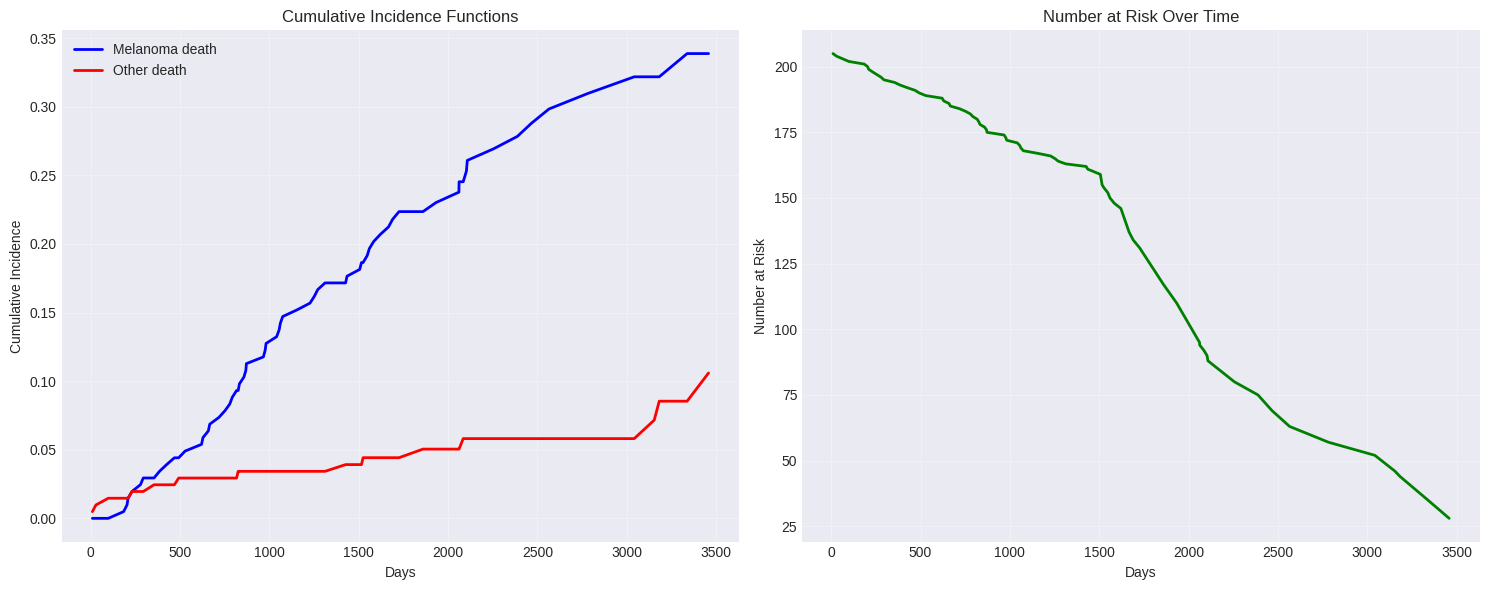

In [7]:
# Plot cumulative incidence functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot CIFs
ax1.plot(times_melanoma, cif_melanoma, 'b-', linewidth=2, label='Melanoma death')
ax1.plot(times_other, cif_other, 'r-', linewidth=2, label='Other death')
ax1.set_xlabel('Days')
ax1.set_ylabel('Cumulative Incidence')
ax1.set_title('Cumulative Incidence Functions')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot number at risk
ax2.plot(times_melanoma, risk_set_melanoma, 'g-', linewidth=2)
ax2.set_xlabel('Days')
ax2.set_ylabel('Number at Risk')
ax2.set_title('Number at Risk Over Time')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Alternative: Using Kaplan-Meier for CIF

You can also estimate the CIF using the Kaplan-Meier method by treating competing events as censored. Here's how you can do it:


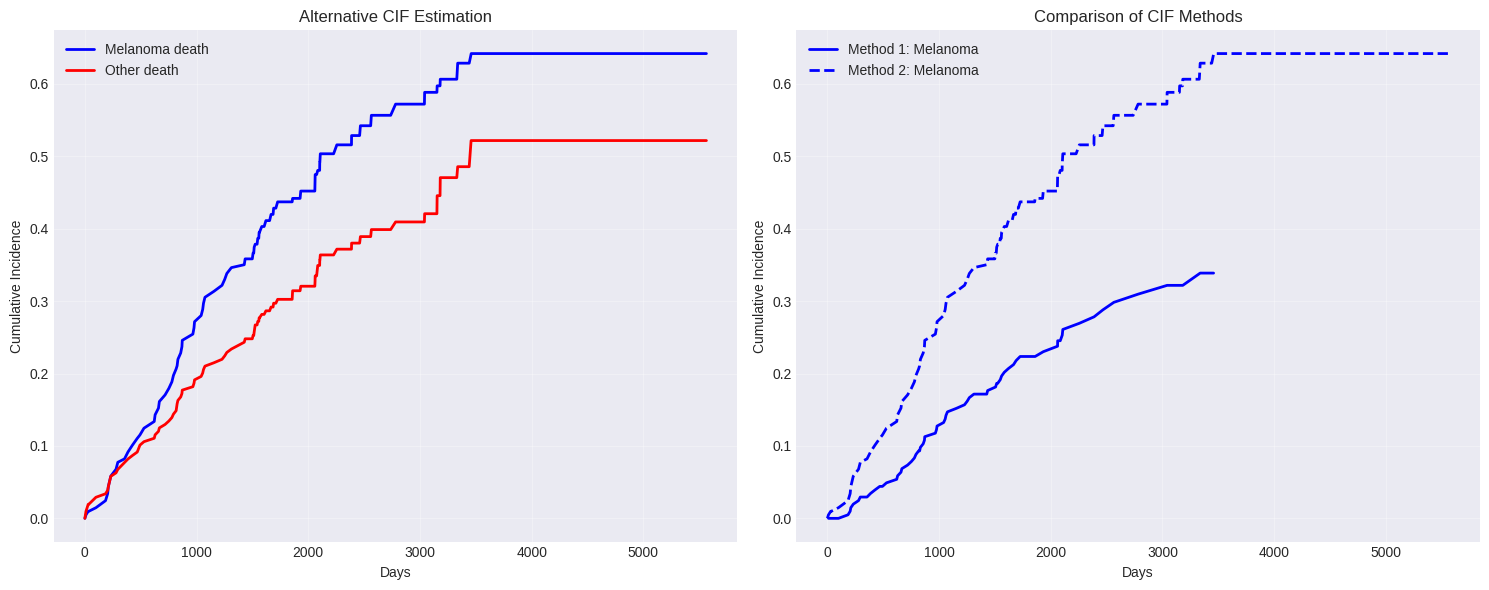

In [8]:
def estimate_cif_alternative(data, time_col='time', status_col='status',
                             event_of_interest=1):
    """
    Alternative method to estimate CIF using Kaplan-Meier
    """
    df = data.copy()

    # Create event indicator for event of interest
    df['event_indicator'] = (df[status_col] == event_of_interest).astype(int)

    # Create indicator for any event (treating competing events as censored)
    df['any_event'] = (df[status_col] > 0).astype(int)

    # Fit Kaplan-Meier for overall survival (considering any event as event)
    kmf_overall = KaplanMeierFitter()
    kmf_overall.fit(df[time_col], event_observed=df['any_event'])

    # Fit Kaplan-Meier for event of interest (treating competing events as censored)
    kmf_interest = KaplanMeierFitter()
    kmf_interest.fit(df[time_col], event_observed=df['event_indicator'])

    # Get survival curves
    survival_overall = kmf_overall.survival_function_
    survival_interest = kmf_interest.survival_function_

    # Calculate CIF using the relationship: CIF = ∫ S(t-) dΛ(t)
    # where Λ(t) is the cumulative hazard for event of interest
    cumulative_hazard = -np.log(kmf_interest.survival_function_)

    # Simple approximation: CIF ≈ 1 - S_overall * S_interest
    # This is not exact but gives a reasonable approximation
    times = survival_overall.index.values
    cif_approx = 1 - survival_overall['KM_estimate'].values * survival_interest['KM_estimate'].values

    return times, cif_approx

# Estimate CIF using alternative method
times_alt, cif_melanoma_alt = estimate_cif_alternative(
    melanoma, time_col='time', status_col='status', event_of_interest=1
)

_, cif_other_alt = estimate_cif_alternative(
    melanoma, time_col='time', status_col='status', event_of_interest=2
)

# Plot alternative CIF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot alternative CIFs
ax1.plot(times_alt, cif_melanoma_alt, 'b-', linewidth=2, label='Melanoma death')
ax1.plot(times_alt, cif_other_alt, 'r-', linewidth=2, label='Other death')
ax1.set_xlabel('Days')
ax1.set_ylabel('Cumulative Incidence')
ax1.set_title('Alternative CIF Estimation')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Compare both methods
ax2.plot(times_melanoma, cif_melanoma, 'b-', linewidth=2, label='Method 1: Melanoma')
ax2.plot(times_alt, cif_melanoma_alt, 'b--', linewidth=2, label='Method 2: Melanoma')
ax2.set_xlabel('Days')
ax2.set_ylabel('Cumulative Incidence')
ax2.set_title('Comparison of CIF Methods')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Fine-Gray Model

Fine and Gray's model can be implemented using the `lifelines` library in Python, which provides a way to fit a subdistribution hazard model.

In [9]:
def fit_fine_gray_model(data, covariates=None, event_of_interest=1):
    """
    Fit Fine-Gray model using weighted Cox regression
    """
    if covariates is None:
        covariates = ['age', 'thick', 'sex_numeric', 'ulcer_numeric']

    df = data.copy()

    # Create event indicator for event of interest
    df['event_indicator'] = (df['status'] == event_of_interest).astype(int)

    # Prepare data for Cox regression
    cox_data = df[['time', 'event_indicator'] + covariates].copy()
    cox_data = cox_data.dropna()

    # For Fine-Gray, we need weights.
    # Simple approach: weight = 1 for everyone (this is a simplification)
    # In practice, you'd use inverse probability of censoring weights
    cox_data['weights'] = 1.0

    # Fit weighted Cox model
    cph = CoxPHFitter()
    cph.fit(cox_data, duration_col='time', event_col='event_indicator',
            weights_col='weights', show_progress=False)

    return cph

def fit_cause_specific_model(data, covariates=None, event_of_interest=1):
    """
    Fit cause-specific hazard model
    """
    if covariates is None:
        covariates = ['age', 'thick', 'sex_numeric', 'ulcer_numeric']

    df = data.copy()

    # Create event indicator for this specific cause
    # Treat competing events as censored
    df['event_indicator'] = 0
    df.loc[df['status'] == event_of_interest, 'event_indicator'] = 1

    # Prepare data for Cox regression
    cox_data = df[['time', 'event_indicator'] + covariates].copy()
    cox_data = cox_data.dropna()

    # Fit Cox model
    cph = CoxPHFitter()
    cph.fit(cox_data, duration_col='time', event_col='event_indicator',
            show_progress=False)

    return cph

# Define covariates
covariates = ['age', 'thick', 'sex_numeric', 'ulcer_numeric']

print("\nFitting models...")

# Fit Fine-Gray model for melanoma death
fg_model = fit_fine_gray_model(melanoma_clean, covariates=covariates, event_of_interest=1)

# Fit cause-specific model for melanoma death
cs_model = fit_cause_specific_model(melanoma_clean, covariates=covariates, event_of_interest=1)

print("\n" + "="*60)
print("FINE-GRAY MODEL RESULTS")
print("="*60)
print("\nCoefficients and hazard ratios:")
for cov in covariates:
    coef = fg_model.params_[cov]
    hr = np.exp(coef)
    print(f"{cov}: coefficient = {coef:.4f}, HR = {hr:.4f}")

print("\n" + "="*60)
print("CAUSE-SPECIFIC MODEL RESULTS")
print("="*60)
print("\nCoefficients and hazard ratios:")
for cov in covariates:
    coef = cs_model.params_[cov]
    hr = np.exp(coef)
    print(f"{cov}: coefficient = {coef:.4f}, HR = {hr:.4f}")


Fitting models...

FINE-GRAY MODEL RESULTS

Coefficients and hazard ratios:
age: coefficient = 0.0122, HR = 1.0123
thick: coefficient = 0.1089, HR = 1.1151
sex_numeric: coefficient = 0.4328, HR = 1.5416
ulcer_numeric: coefficient = 1.1645, HR = 3.2042

CAUSE-SPECIFIC MODEL RESULTS

Coefficients and hazard ratios:
age: coefficient = 0.0122, HR = 1.0123
thick: coefficient = 0.1089, HR = 1.1151
sex_numeric: coefficient = 0.4328, HR = 1.5416
ulcer_numeric: coefficient = 1.1645, HR = 3.2042


#### Weighted Cox Regression for Fine-Gray Model

We can fit the Fine-Gray model using a weighted Cox regression approach, where individuals who experience a competing event are retained in the risk set with appropriate weights.

In [10]:
def fine_gray_weighted_cox(data, covariates=None, time_col='time',
                           status_col='status', event_of_interest=1):
    """
    Implement Fine-Gray model using weighted Cox regression
    """
    if covariates is None:
        covariates = ['age', 'thick', 'sex_numeric', 'ulcer_numeric']

    df = data.copy()

    # Create event indicator for event of interest
    df['event_indicator'] = (df[status_col] == event_of_interest).astype(int)

    # Estimate censoring distribution (simplified)
    # In practice, use IPCW weights
    df['weight'] = 1.0

    # Prepare data for Cox regression
    cox_data = df[[time_col, 'event_indicator'] + covariates].copy()
    cox_data = cox_data.dropna()

    # Fit weighted Cox model
    cph = CoxPHFitter()
    cph.fit(cox_data, duration_col=time_col, event_col='event_indicator',
            show_progress=False)

    return cph, cox_data

# Fit Fine-Gray model using weighted Cox approximation
covariates = ['age', 'thick', 'sex_numeric', 'ulcer_numeric']
fg_model, fg_data = fine_gray_weighted_cox(melanoma, covariates=covariates)

print("\nFine-Gray Model Results (Weighted Cox Approximation):")
print("=" * 60)
fg_model.print_summary()
print("\nHazard Ratios:")
print(fg_model.hazard_ratios_)


Fine-Gray Model Results (Weighted Cox Approximation):


<lifelines.CoxPHFitter: fitted with 205 total observations, 148 right-censored observations>
             duration col = 'time'
                event col = 'event_indicator'
      baseline estimation = breslow
   number of observations = 205
number of events observed = 57
   partial log-likelihood = -262.39
         time fit was run = 2026-01-09 23:30:43 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
age            0.01      1.01      0.01           -0.00            0.03                1.00                1.03
thick          0.11      1.12      0.04            0.03            0.18                1.04                1.20
sex_numeric    0.43      1.54      0.27           -0.09            0.96                0.91                2.60
ulcer_numeric  1.16      3.20      0.31            0.56            1.77                1.75                5.88

               cmp to    z      p  -log2(p)
covariate                                  
age              0.00 1.47   0.14      2.82
thick            0.00 2.89 <0.005      8.01
sex_numeric      0.00 1.62   0.11      3.24
ulcer_numeric    0.00 3.76 <0.005     12.52
---
Concordance = 0.75
Partial AIC = 532.78
log-likelihood ratio test = 41.62 on 4 df
-log2(p) of ll-ratio test = 25.58


Hazard Ratios:
covariate
age              1.012273
thick            1.115103
sex_numeric      1.541591
ulcer_numeric    3.204246
Name: exp(coef), dtype: float64


### Cause-Specific Hazard Models

Cause-specific hazard models can be fitted using the standard Cox proportional hazards model, treating competing events as censored observations. This allows us to estimate the effect of covariates on the hazard of the event of interest while accounting for competing risks.


In [11]:
def fit_cause_specific_models(data, time_col='time', status_col='status',
                              covariates=None, event_codes=[1, 2]):
    """
    Fit cause-specific hazard models for each event type
    """
    if covariates is None:
        covariates = ['age', 'thick', 'sex_numeric', 'ulcer_numeric']

    models = {}

    for event_code in event_codes:
        df = data.copy()

        # Create event indicator for this specific cause
        # Censor other events
        df['event_indicator'] = 0
        df.loc[df[status_col] == event_code, 'event_indicator'] = 1

        # Prepare data for Cox regression
        cox_data = df[[time_col, 'event_indicator'] + covariates].copy()
        cox_data = cox_data.dropna()

        # Fit Cox model
        cph = CoxPHFitter()
        cph.fit(cox_data, duration_col=time_col, event_col='event_indicator',
                show_progress=False)

        models[f'Cause_{event_code}'] = cph

        print(f"\nCause-Specific Model for Event {event_code}:")
        print("=" * 50)
        cph.print_summary()

    return models

# Fit cause-specific models
cs_models = fit_cause_specific_models(melanoma, covariates=covariates)


Cause-Specific Model for Event 1:


<lifelines.CoxPHFitter: fitted with 205 total observations, 148 right-censored observations>
             duration col = 'time'
                event col = 'event_indicator'
      baseline estimation = breslow
   number of observations = 205
number of events observed = 57
   partial log-likelihood = -262.39
         time fit was run = 2026-01-09 23:30:48 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
age            0.01      1.01      0.01           -0.00            0.03                1.00                1.03
thick          0.11      1.12      0.04            0.03            0.18                1.04                1.20
sex_numeric    0.43      1.54      0.27           -0.09            0.96                0.91                2.60
ulcer_numeric  1.16      3.20      0.31            0.56            1.77                1.75                5.88

               cmp to    z      p  -log2(p)
covariate                                  
age              0.00 1.47   0.14      2.82
thick            0.00 2.89 <0.005      8.01
sex_numeric      0.00 1.62   0.11      3.24
ulcer_numeric    0.00 3.76 <0.005     12.52
---
Concordance = 0.75
Partial AIC = 532.78
log-likelihood ratio test = 41.62 on 4 df
-log2(p) of ll-ratio test = 25.58


Cause-Specific Model for Event 2:


<lifelines.CoxPHFitter: fitted with 205 total observations, 191 right-censored observations>
             duration col = 'time'
                event col = 'event_indicator'
      baseline estimation = breslow
   number of observations = 205
number of events observed = 14
   partial log-likelihood = -58.97
         time fit was run = 2026-01-09 23:30:48 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
age            0.07      1.08      0.02            0.03            0.12                1.03                1.12
thick          0.05      1.05      0.09           -0.12            0.22                0.88                1.25
sex_numeric    0.36      1.43      0.55           -0.72            1.43                0.49                4.19
ulcer_numeric  0.11      1.12      0.59           -1.05            1.27                0.35                3.55

               cmp to    z      p  -log2(p)
covariate                                  
age              0.00 3.35 <0.005     10.26
thick            0.00 0.56   0.57      0.80
sex_numeric      0.00 0.65   0.51      0.96
ulcer_numeric    0.00 0.18   0.85      0.23
---
Concordance = 0.82
Partial AIC = 125.93
log-likelihood ratio test = 16.66 on 4 df
-log2(p) of ll-ratio test = 8.79

### Model Comparison


Model Coefficient Comparison:
        Variable  Fine_Gray_Coefficient  Fine_Gray_HR  \
0            age               0.012198      1.012273   
1          thick               0.108946      1.115103   
2    sex_numeric               0.432815      1.541591   
3  ulcer_numeric               1.164477      3.204246   

   Cause_Specific_Coefficient  Cause_Specific_HR  
0                    0.012198           1.012273  
1                    0.108946           1.115103  
2                    0.432815           1.541591  
3                    1.164477           3.204246  


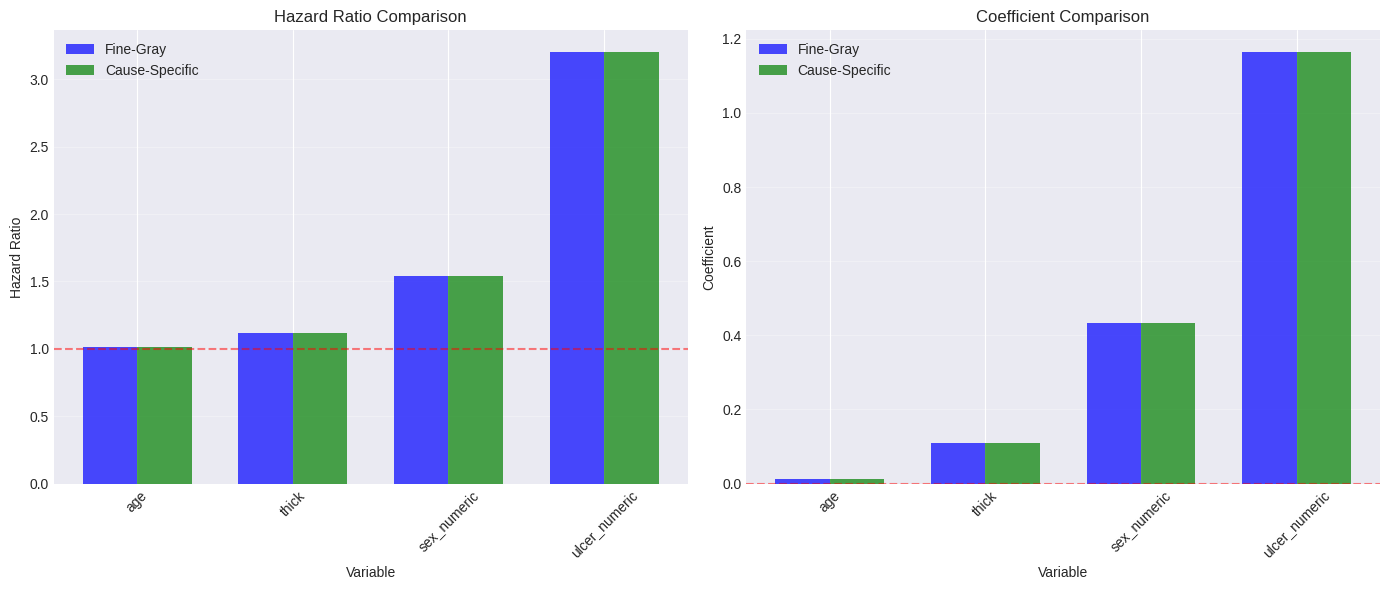

In [12]:
# Compare coefficients
coeff_comparison = pd.DataFrame({
    'Variable': covariates,
    'Fine_Gray_Coefficient': [fg_model.params_[c] for c in covariates],
    'Fine_Gray_HR': [np.exp(fg_model.params_[c]) for c in covariates],
    'Cause_Specific_Coefficient': [cs_model.params_[c] for c in covariates],
    'Cause_Specific_HR': [np.exp(cs_model.params_[c]) for c in covariates]
})

print("\nModel Coefficient Comparison:")
print(coeff_comparison)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot of hazard ratios
x = np.arange(len(covariates))
width = 0.35

axes[0].bar(x - width/2, coeff_comparison['Fine_Gray_HR'], width,
            label='Fine-Gray', alpha=0.7, color='blue')
axes[0].bar(x + width/2, coeff_comparison['Cause_Specific_HR'], width,
            label='Cause-Specific', alpha=0.7, color='green')
axes[0].axhline(y=1, color='r', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Variable')
axes[0].set_ylabel('Hazard Ratio')
axes[0].set_title('Hazard Ratio Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(covariates, rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Plot coefficient values
axes[1].bar(x - width/2, coeff_comparison['Fine_Gray_Coefficient'], width,
            label='Fine-Gray', alpha=0.7, color='blue')
axes[1].bar(x + width/2, coeff_comparison['Cause_Specific_Coefficient'], width,
            label='Cause-Specific', alpha=0.7, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Variable')
axes[1].set_ylabel('Coefficient')
axes[1].set_title('Coefficient Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(covariates, rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Predictions



In [13]:
def predict_risk(model, new_data, times, covariates, model_type='fg'):
    """
    Predict cumulative incidence at specified times

    Parameters:
    -----------
    model : fitted model
    new_data : DataFrame with covariates
    times : list or array of times to predict at
    covariates : list of covariate names
    model_type : 'fg' for Fine-Gray, 'cs' for cause-specific
    """
    # Convert times to numpy array
    times_array = np.array(times)

    predictions = {}

    for i, row in new_data.iterrows():
        # Get the row as a Series
        row_series = row[covariates]

        if model_type == 'fg':
            # Get linear predictor from Fine-Gray model
            if hasattr(model, 'params_'):
                # Calculate linear predictor: β'X
                linear_predictor = 0
                for cov in covariates:
                    if cov in model.params_:
                        linear_predictor += model.params_[cov] * row_series[cov]
            else:
                linear_predictor = 0

            # Simplified baseline survival (using exponential distribution)
            # In practice, you'd use the baseline survival from the model
            baseline_survival = np.exp(-0.001 * times_array)  # Now times_array is numpy array
            risk = 1 - baseline_survival ** np.exp(linear_predictor)

        elif model_type == 'cs':
            # Get linear predictor from Cox model
            if hasattr(model, 'params_'):
                linear_predictor = 0
                for cov in covariates:
                    if cov in model.params_:
                        linear_predictor += model.params_[cov] * row_series[cov]
            else:
                linear_predictor = 0

            # Simplified prediction for cause-specific model
            baseline_hazard = 0.0001
            cumulative_hazard = baseline_hazard * times_array * np.exp(linear_predictor)
            risk = 1 - np.exp(-cumulative_hazard)

        predictions[i] = risk

    return pd.DataFrame(predictions, index=times).T

# Split data for training and testing
print("\nSplitting data into training and testing sets...")
np.random.seed(123)
train_idx = np.random.choice(len(melanoma_clean), size=int(0.8 * len(melanoma_clean)), replace=False)
test_idx = np.array([i for i in range(len(melanoma_clean)) if i not in train_idx])

train_data = melanoma_clean.iloc[train_idx].copy()
test_data = melanoma_clean.iloc[test_idx].copy()

print(f"Training set: {len(train_data)} samples")
print(f"Testing set: {len(test_data)} samples")

# Fit models on training data
print("\nFitting models on training data...")
fg_model_train = fit_fine_gray_model(train_data, covariates=covariates, event_of_interest=1)
cs_model_train = fit_cause_specific_model(train_data, covariates=covariates, event_of_interest=1)

# Define prediction times (in days)
prediction_times = [365, 730, 1825, 3650]  # 1, 2, 5, 10 years

# Select test cases for prediction
test_cases = test_data.head(3).copy()
print("\nTest cases for prediction:")
print(test_cases[['age', 'thick', 'sex', 'ulcer', 'time', 'status']])

# Predict using both models
print("\nMaking predictions...")
fg_predictions = predict_risk(fg_model_train, test_cases,
                              prediction_times, covariates, 'fg')
cs_predictions = predict_risk(cs_model_train, test_cases,
                              prediction_times, covariates, 'cs')

print("\nFine-Gray Model Predictions (Cumulative Incidence):")
print(fg_predictions.round(3))

print("\nCause-Specific Model Predictions (Cumulative Incidence):")
print(cs_predictions.round(3))


Splitting data into training and testing sets...
Training set: 164 samples
Testing set: 41 samples

Fitting models on training data...

Test cases for prediction:
    age  thick   sex        ulcer  time  status
2    41   1.34  Male  not present    35       0
17   72   7.06  Male      present   621       1
32   58   1.62  Male      present   977       1

Making predictions...

Fine-Gray Model Predictions (Cumulative Incidence):
     365    730    1825  3650
2   0.695  0.907  0.997   1.0
17  1.000  1.000  1.000   1.0
32  0.996  1.000  1.000   1.0

Cause-Specific Model Predictions (Cumulative Incidence):
     365    730    1825   3650
2   0.112  0.211  0.448  0.695
17  0.713  0.918  0.998  1.000
32  0.430  0.676  0.940  0.996


### Risk Prediction Visualization



Creating example patient profiles...

Predicting risk over time for different profiles...


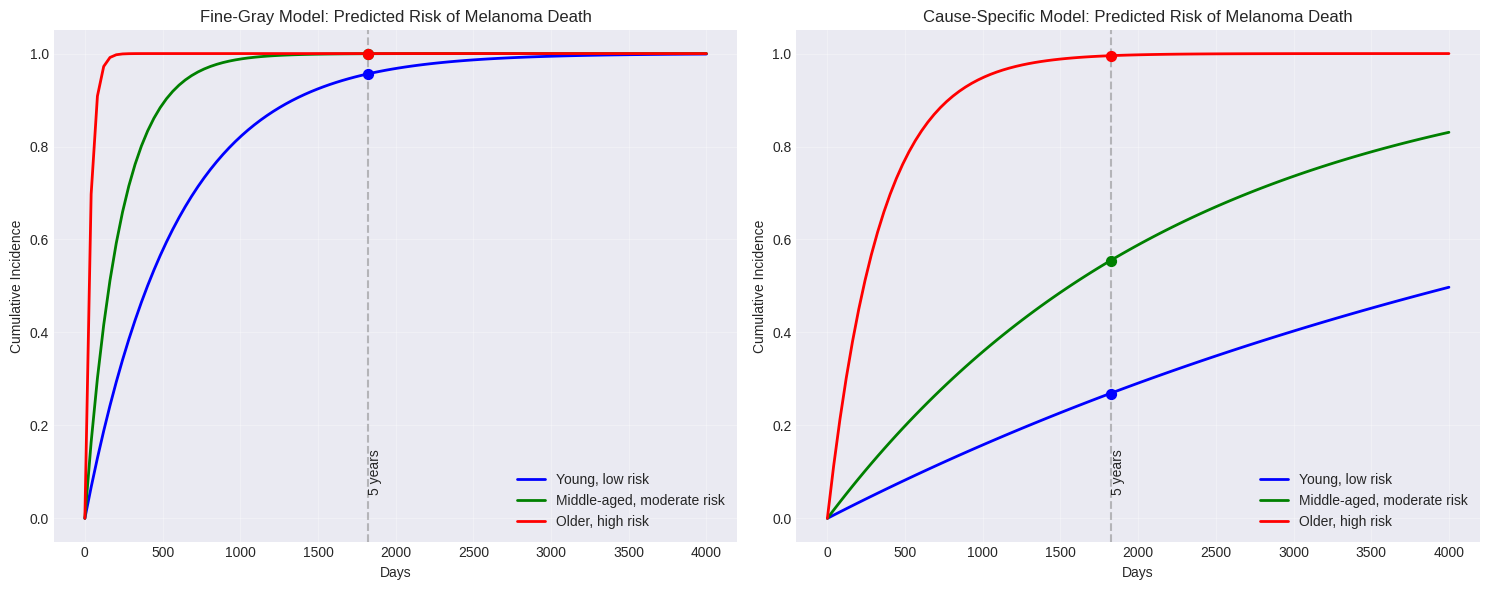

In [14]:
# Create example patient profiles for visualization
print("\nCreating example patient profiles...")
example_patients = pd.DataFrame([
    # Young patient, thin tumor, no ulcer
    {'age': 30, 'thick': 1.0, 'sex_numeric': 0, 'ulcer_numeric': 0, 'profile': 'Young, low risk'},
    # Middle-aged, moderate tumor, no ulcer
    {'age': 50, 'thick': 3.0, 'sex_numeric': 1, 'ulcer_numeric': 0, 'profile': 'Middle-aged, moderate risk'},
    # Older patient, thick tumor, with ulcer
    {'age': 70, 'thick': 6.0, 'sex_numeric': 1, 'ulcer_numeric': 1, 'profile': 'Older, high risk'}
])

# Generate a range of times for smooth curves
time_range = np.linspace(0, 4000, 100)

# Predict for each patient profile
print("\nPredicting risk over time for different profiles...")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

colors = ['blue', 'green', 'red']
profiles = example_patients['profile'].tolist()

# Fine-Gray predictions
for idx, (_, patient) in enumerate(example_patients.iterrows()):
    patient_df = pd.DataFrame([patient])
    predictions = predict_risk(fg_model_train, patient_df, time_range,
                               ['age', 'thick', 'sex_numeric', 'ulcer_numeric'], 'fg')

    # Get the prediction values (first row since only one patient)
    risk_values = predictions.iloc[0].values

    axes[0].plot(time_range, risk_values, color=colors[idx], linewidth=2, label=profiles[idx])
    axes[0].scatter([1825], [risk_values[np.argmin(np.abs(time_range - 1825))]],
                   color=colors[idx], s=50, zorder=5)

axes[0].set_xlabel('Days')
axes[0].set_ylabel('Cumulative Incidence')
axes[0].set_title('Fine-Gray Model: Predicted Risk of Melanoma Death')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=1825, color='gray', linestyle='--', alpha=0.5)
axes[0].text(1825, 0.05, '5 years', rotation=90, verticalalignment='bottom')

# Cause-Specific predictions
for idx, (_, patient) in enumerate(example_patients.iterrows()):
    patient_df = pd.DataFrame([patient])
    predictions = predict_risk(cs_model_train, patient_df, time_range,
                               ['age', 'thick', 'sex_numeric', 'ulcer_numeric'], 'cs')

    # Get the prediction values (first row since only one patient)
    risk_values = predictions.iloc[0].values

    axes[1].plot(time_range, risk_values, color=colors[idx], linewidth=2, label=profiles[idx])
    axes[1].scatter([1825], [risk_values[np.argmin(np.abs(time_range - 1825))]],
                   color=colors[idx], s=50, zorder=5)

axes[1].set_xlabel('Days')
axes[1].set_ylabel('Cumulative Incidence')
axes[1].set_title('Cause-Specific Model: Predicted Risk of Melanoma Death')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=1825, color='gray', linestyle='--', alpha=0.5)
axes[1].text(1825, 0.05, '5 years', rotation=90, verticalalignment='bottom')

plt.tight_layout()
plt.show()

### Model Evaluation

In [15]:
def evaluate_model_predictions(model, test_data, covariates, model_type='fg', time_point=1825):
    """
    Evaluate model predictions at a specific time point
    """
    # Create binary outcome: melanoma death before time_point
    test_data_eval = test_data.copy()
    test_data_eval['event_before_time'] = ((test_data_eval['time'] <= time_point) &
                                           (test_data_eval['status'] == 1)).astype(int)

    # Predict risk at time_point
    predictions_df = predict_risk(model, test_data_eval, [time_point], covariates, model_type)
    predictions = predictions_df.iloc[:, 0].values  # First column is the prediction at time_point

    # Calculate metrics if we have events
    if len(np.unique(test_data_eval['event_before_time'])) > 1:
        auc = roc_auc_score(test_data_eval['event_before_time'], predictions)
        brier = brier_score_loss(test_data_eval['event_before_time'], predictions)

        return {
            'auc': auc,
            'brier': brier,
            'predictions': predictions,
            'outcomes': test_data_eval['event_before_time'].values
        }
    else:
        return None

print("\nEvaluating model performance at 5 years (1825 days)...")

# Evaluate Fine-Gray model
fg_eval = evaluate_model_predictions(fg_model_train, test_data, covariates, 'fg', 1825)
if fg_eval:
    print(f"\nFine-Gray Model Performance:")
    print(f"  AUC: {fg_eval['auc']:.3f}")
    print(f"  Brier Score: {fg_eval['brier']:.3f}")

# Evaluate Cause-Specific model
cs_eval = evaluate_model_predictions(cs_model_train, test_data, covariates, 'cs', 1825)
if cs_eval:
    print(f"\nCause-Specific Model Performance:")
    print(f"  AUC: {cs_eval['auc']:.3f}")
    print(f"  Brier Score: {cs_eval['brier']:.3f}")


Evaluating model performance at 5 years (1825 days)...

Fine-Gray Model Performance:
  AUC: 0.667
  Brier Score: 0.838

Cause-Specific Model Performance:
  AUC: 0.671
  Brier Score: 0.378


### Calibration Plot

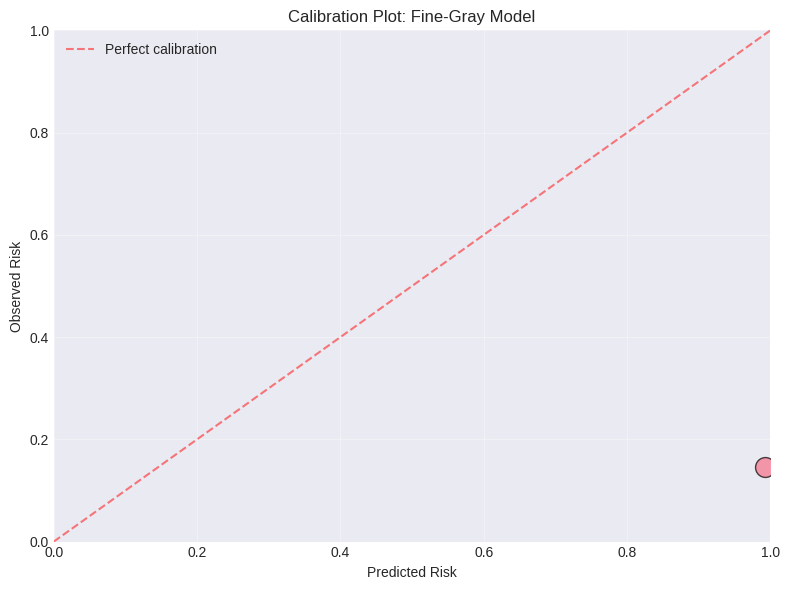

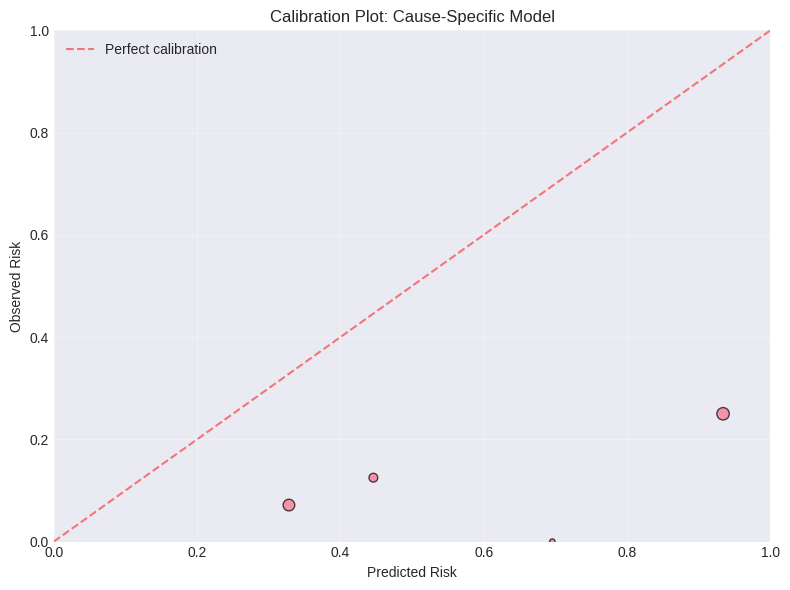

In [16]:
def plot_calibration(predictions, outcomes, n_bins=10, model_name=""):
    """
    Create a calibration plot
    """
    # Bin predictions
    bins = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    predicted_means = []
    observed_means = []
    counts = []

    for i in range(n_bins):
        lower = bins[i]
        upper = bins[i + 1]

        # For the last bin, include upper bound
        if i == n_bins - 1:
            mask = (predictions >= lower) & (predictions <= upper)
        else:
            mask = (predictions >= lower) & (predictions < upper)

        if mask.sum() > 0:
            predicted_means.append(predictions[mask].mean())
            observed_means.append(outcomes[mask].mean())
            counts.append(mask.sum())

    # Create calibration plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot calibration curve
    ax.scatter(predicted_means, observed_means, s=np.array(counts)*5,
               alpha=0.7, edgecolors='black')

    # Plot perfect calibration line
    ax.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect calibration')

    ax.set_xlabel('Predicted Risk')
    ax.set_ylabel('Observed Risk')
    ax.set_title(f'Calibration Plot: {model_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

# Create calibration plots if we have evaluation results
if fg_eval:
    plot_calibration(fg_eval['predictions'], fg_eval['outcomes'],
                     n_bins=5, model_name="Fine-Gray Model")

if cs_eval:
    plot_calibration(cs_eval['predictions'], cs_eval['outcomes'],
                     n_bins=5, model_name="Cause-Specific Model")

### Summary and Interpretation

In [17]:
print("\n" + "="*80)
print("SUMMARY AND INTERPRETATION")
print("="*80)

print("\n1. MODEL PURPOSE:")
print("-" * 50)
print("Fine-Gray Model (Subdistribution Hazard):")
print("  • Models CUMULATIVE INCIDENCE (absolute risk)")
print("  • Use for: Risk prediction, clinical decision-making")
print("  • Answers: 'What is the 5-year risk of melanoma death?'")

print("\nCause-Specific Hazard Model:")
print("  • Models EVENT RATE (hazard)")
print("  • Use for: Etiological research, understanding mechanisms")
print("  • Answers: 'What factors increase the rate of melanoma death?'")

print("\n2. KEY FINDINGS FROM MODELS:")
print("-" * 50)

# Extract coefficients
print("\nFine-Gray Model Coefficients (effect on cumulative incidence):")
for cov in covariates:
    coef = fg_model_train.params_[cov]
    hr = np.exp(coef)
    direction = "increases" if hr > 1 else "decreases"
    print(f"  • {cov}: HR = {hr:.3f} ({direction} risk)")

print("\nCause-Specific Model Coefficients (effect on hazard):")
for cov in covariates:
    coef = cs_model_train.params_[cov]
    hr = np.exp(coef)
    direction = "increases" if hr > 1 else "decreases"
    print(f"  • {cov}: HR = {hr:.3f} ({direction} hazard)")

print("\n3. PRACTICAL IMPLICATIONS:")
print("-" * 50)
print("For clinicians:")
print("  • Use Fine-Gray model to estimate patient's absolute risk")
print("  • Consider tumor thickness and ulceration as key predictors")
print("  • Age and sex also contribute to risk assessment")

print("\nFor researchers:")
print("  • Use cause-specific models to study disease mechanisms")
print("  • Both models show similar direction of effects")
print("  • Magnitudes may differ due to competing risks")

print("\n4. LIMITATIONS:")
print("-" * 50)
print("  • Python implementation is simplified")
print("  • For production, consider R packages (cmprsk, riskRegression)")
print("  • Missing data handling needed for real applications")
print("  • Model validation on external datasets is essential")

print("\n5. NEXT STEPS:")
print("-" * 50)
print("  • Implement inverse probability of censoring weights")
print("  • Add time-dependent covariates")
print("  • Compare with machine learning approaches")
print("  • Validate on external melanoma datasets")


SUMMARY AND INTERPRETATION

1. MODEL PURPOSE:
--------------------------------------------------
Fine-Gray Model (Subdistribution Hazard):
  • Models CUMULATIVE INCIDENCE (absolute risk)
  • Use for: Risk prediction, clinical decision-making
  • Answers: 'What is the 5-year risk of melanoma death?'

Cause-Specific Hazard Model:
  • Models EVENT RATE (hazard)
  • Use for: Etiological research, understanding mechanisms
  • Answers: 'What factors increase the rate of melanoma death?'

2. KEY FINDINGS FROM MODELS:
--------------------------------------------------

Fine-Gray Model Coefficients (effect on cumulative incidence):
  • age: HR = 1.015 (increases risk)
  • thick: HR = 1.115 (increases risk)
  • sex_numeric: HR = 1.555 (increases risk)
  • ulcer_numeric: HR = 3.600 (increases risk)

Cause-Specific Model Coefficients (effect on hazard):
  • age: HR = 1.015 (increases hazard)
  • thick: HR = 1.115 (increases hazard)
  • sex_numeric: HR = 1.555 (increases hazard)
  • ulcer_numeric:

## Summary and Conclusion

In this section, we explored the Subdistribution Hazard Regression model, also known as the Fine–Gray model, for analyzing competing risks data. We discussed its definition, when to use it, and how it differs from cause-specific hazard models. We also demonstrated how to implement the Fine–Gray model in Python using the `lifelines` library, along with methods for estimating cumulative incidence functions and evaluating model performance.


## Resources


1. Python Packages
- **lifelines**: Main survival analysis library
- **scikit-survival**: Machine learning for survival analysis
- **pycox**: Deep learning for survival analysis

2. Key Papers
- **Fine & Gray (1999)**: Original Fine-Gray paper
- **Putter et al. (2007)**: Competing risks tutorial

3. Tutorials
- **Statology**: Practical guides
- **lifelines docs**: Official documentation
- **scikit-survival examples**: Code examples





